In [1]:
import os
import numpy as np
import torch
from torch import nn
import math
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import os
torch.manual_seed(111)

In [2]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    return image_grid

In [3]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [5]:
train_set = torchvision.datasets.FashionMNIST(
        root=".", train=True, download=True, transform=transform)

In [6]:
batch_size = 32 
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [7]:
def display_samples(ds, row, col):
    ds_iter = iter(ds)
    for j in range(row*col):
        example_sample = next(ds_iter)
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(example_sample[0], cmap="gray_r")
    plt.show()

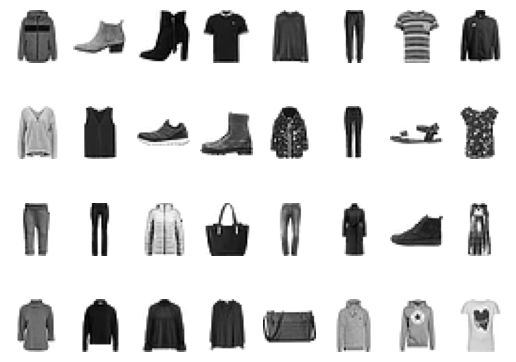

In [8]:
display_samples(next(iter(train_loader))[0], 4, 8)

## Class Discriminator

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),     # 28X28 =  784
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output
        
discriminator = Discriminator().to(device=device)

In [10]:
print(discriminator)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


## Class generator

In [11]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

generator = Generator().to(device=device)

In [12]:
print(generator)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)


In [13]:
def get_noise(n, z_dim, device='cpu'):
    # Create noise
    # n - the number of samples to generate
    # z_dim - the dimension of noise vector, scalar
    return torch.randn(n, z_dim, device=device)
## Function to caculate discriminator's loss and generator's loss
def get_gen_loss(generator, discriminator, criterion, num_images, z_dim, device):
    # Create noise
    fake_noise = get_noise(num_images, z_dim, device)
    fake = generator(fake_noise)
    disc_fake_pred = discriminator(fake)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    return gen_loss

def get_dis_loss(generator, discriminator, criterion, real, num_images, z_dim, device):
    # fake
    fake_noise = get_noise(num_images, z_dim=z_dim, device=device)
    fake = generator(fake_noise)
    disc_fake_predict = discriminator(fake.detach())
    disc_fake_loss = criterion(disc_fake_predict, torch.zeros_like(disc_fake_predict))
    # real
    dis_real_pred = discriminator(real)
    disc_real_loss = criterion(dis_real_pred, torch.ones_like(dis_real_pred))
    # loss
    disc_loss = (disc_fake_loss + disc_real_loss) / 2

    return disc_loss

## Training

In [14]:
lr = 0.0002
num_epochs = 20
loss_function = nn.BCELoss()
cur_step = 0
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

writer_fake = SummaryWriter(f"runs/GAN_FASHION_MNIST/fake_images")
writer_real = SummaryWriter(f"runs/GAN_FASHION_MNIST/real_images")

In [15]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Данные для тренировки дискриминатора
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device)
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device)
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels))
        # Обучение дискриминатора
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Данные для обучения генератора
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device)
        

        # Обучение генератора
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Показываем loss
        if n == batch_size - 1:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {n}/{len(train_loader)} \
                      Loss disc: {loss_discriminator:.4f}, loss gen: {loss_generator:.4f}"
            )
            # print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            # print(f"Epoch: {epoch} Loss G.: {loss_generator}")
            with torch.no_grad():
                fake_noise = get_noise(batch_size, 100, device)
                fake = generator(fake_noise)
                img_grid_fake =show_tensor_images(fake)
                img_grid_real = show_tensor_images(real_samples)
                mean_generator_loss = 0
                mean_discriminator_loss = 0

                writer_fake.add_image(
                    "Mnist Fake Images", img_grid_fake, global_step=cur_step
                )
                writer_real.add_image(
                    "Mnist Real Images", img_grid_real, global_step=cur_step
                )
                cur_step += 1


Epoch [0/20] Batch 31/1875                       Loss disc: 0.7102, loss gen: 1.1743
Epoch [1/20] Batch 31/1875                       Loss disc: 0.1763, loss gen: 2.5312
Epoch [2/20] Batch 31/1875                       Loss disc: 0.2003, loss gen: 2.6089
Epoch [3/20] Batch 31/1875                       Loss disc: 0.3531, loss gen: 2.7921
Epoch [4/20] Batch 31/1875                       Loss disc: 0.3440, loss gen: 1.9442
Epoch [5/20] Batch 31/1875                       Loss disc: 0.4534, loss gen: 1.6215
Epoch [6/20] Batch 31/1875                       Loss disc: 0.4789, loss gen: 1.3538
Epoch [7/20] Batch 31/1875                       Loss disc: 0.4137, loss gen: 1.3239
Epoch [8/20] Batch 31/1875                       Loss disc: 0.4214, loss gen: 1.6857
Epoch [9/20] Batch 31/1875                       Loss disc: 0.5364, loss gen: 1.0381
Epoch [10/20] Batch 31/1875                       Loss disc: 0.7339, loss gen: 1.3758
Epoch [11/20] Batch 31/1875                       Loss disc: 0.3

In [16]:
torch.save(generator, '/home/tuandinh/Desktop/GAN_REARCH_2023/models/generator_10')
torch.save(discriminator, '/home/tuandinh/Desktop/GAN_REARCH_2023/models/discriminator_10')

## Apply my model

In [17]:
generator = torch.load('/home/tuandinh/Desktop/GAN_REARCH_2023/models/generator_10', map_location = device)

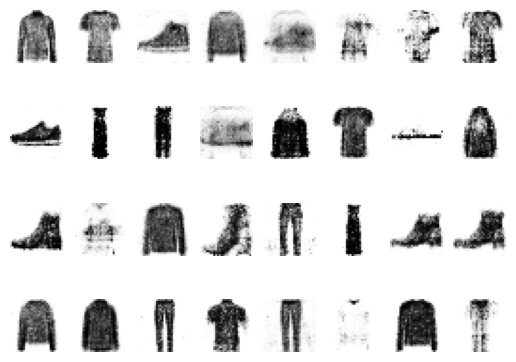

In [18]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.cpu().detach() # show_tensor_images(generated_samples)
# plt.imshow(generated_samples)
display_samples(generated_samples, 4, 8)